In [1]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv

import os
from langchain_huggingface import HuggingFaceEmbeddings
import faiss
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain_community.utilities import SQLDatabase
from langchain.agents import initialize_agent, AgentType

load_dotenv()

True

In [2]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "ConversationalAIBot"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["HUGGINGFACE_API_KEY"] = os.getenv("HUGGINGFACE_API_KEY")

Embedding Model

In [3]:
#Vector Embeddings (Embedding Model Output features : 384)

from langchain.embeddings import HuggingFaceEmbeddings
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2", model_kwargs = {"device" : "cpu"})
embedding_model

C:\Users\v-niranr\AppData\Local\Temp\ipykernel_32912\3273188620.py:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2", model_kwargs = {"device" : "cpu"})
c:\Users\v-niranr\OneDrive - Microsoft\Desktop\Telecom Usecase\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


HuggingFaceEmbeddings(client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
), model_name='sentence-transformers/all-MiniLM-L6-v2', cache_folder=None, model_kwargs={'device': 'cpu'}, encode_kwargs={}, multi_process=False, show_progress=False)

LLM Model

In [4]:
model = ChatGroq(temperature=0, model_name="deepseek-r1-distill-llama-70b", streaming=True)

In [5]:
#Check 

print(model.invoke("Hi Google").content)

<think>

</think>

Hello! How can I assist you today? 😊


Loading Vector Database

In [ ]:
import pandas as pd
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import Document

# Step 1: Load your CSV file
df = pd.read_csv(r'C:\Users\v-niranr\OneDrive - Microsoft\Desktop\Telecom Usecase\Data\bitext-telco-llm-chatbot-training-dataset.csv')  # Replace with your filename

# Step 2: Convert each row to a readable text block
text_data = []
for _, row in df.iterrows():
    text_block = "\n".join([f"{col}: {row[col]}" for col in df.columns])
    text_data.append(text_block)

# Step 3: Optional – Split long text blocks
splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=50)
texts = []
for block in text_data:
    texts.extend(splitter.split_text(block))

# Step 4: Create LangChain Document objects
documents = [Document(page_content=t) for t in texts]

# # Step 5: Load embedding model
# embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Step 6: Create FAISS DB
vector_db = FAISS.from_documents(documents, embedding_model)

# Step 7: Save DB locally
vector_db.save_local(".telecomusecase_FAISS_DB")

print("✅ CSV data embedded and saved to FAISS DB.")


In [43]:
#Local
from langchain_community.vectorstores import FAISS
from langchain_community.docstore import InMemoryDocstore

local_vector_db = FAISS.load_local(".telecomusecase_FAISS_DB",
                                    embeddings=embedding_model,
                                    allow_dangerous_deserialization=True)

In [7]:
vector_db = local_vector_db.as_retriever(search_kwargs={"k":2})

vector_db.invoke("I am facing internet issues and my screen is buffereing")

[Document(id='be08df17-4d74-439c-ab04-c794e21568bb', metadata={}, page_content='instruction: i got to report poor internet signal covedrage i need help\nintent: report_poor_signal_coverage\ncategory: COMPLAINTS\ntags: BCLQZ\nresponse: We recognize the importance of reliable signal coverage for effective communication. Please follow the steps below to report any issues you are experiencing with poor signal coverage:'),
 Document(id='a3b8c6c0-0701-4c44-a1ee-7bd99e4a07b1', metadata={}, page_content='This procedure will furnish you with details pertaining to the internet solutions available in your vicinity. Should you require additional support, do not hesitate to reach out.')]

#### Lang Graph Workflow

For Intent classification Using Pydantic output Parser

In [9]:
from typing import TypedDict, List, Optional

class AgentState(TypedDict):
    messages: List
    customer_id: Optional[str]
    intent: Optional[str]
    user_query: Optional[str]
    customer_data: Optional[str]
    retrieved_context: Optional[str]

In [10]:
#Using pydantic

from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser

class Intent_Classifier(BaseModel):
    """Intent Classifier"""
    customer_id: str = Field(description="The customer ID in the format CUSTXXXX")
    intent: str = Field(description="Intent of the user query")
    query: str = Field(description="User query")
    Reasoning: str = Field(description='Reasoning behind topic selection')


parser = PydanticOutputParser(pydantic_object=Intent_Classifier)

In [11]:
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"description": "Intent Classifier", "properties": {"customer_id": {"description": "The customer ID in the format CUSTXXXX", "title": "Customer Id", "type": "string"}, "intent": {"description": "Intent of the user query", "title": "Intent", "type": "string"}, "query": {"description": "User query", "title": "Query", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["customer_id", "intent", "query", "Reasoning"]}
```


Creating State Graph using Langflow

In [12]:
import operator
from typing import List
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.tools import tool
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.prebuilt import ToolNode

In [13]:
llm = ChatGroq(temperature=0, model_name="deepseek-r1-distill-llama-70b", streaming=True)

In [ ]:
# #Defining State
# class AgentState(TypedDict):
#     messages: Annotated[Sequence[BaseMessage], operator.add]

Supervisor Node

In [14]:
from langchain.prompts import PromptTemplate

def supervisor_node(state: AgentState) -> AgentState:
    print("--------------------------Supervisor---------------------------")
    user_question = state["messages"][-1].content

    template  = """
        You are a telecom assistant that classifies the user's intent into one of the following:
    - Plan: If the user is asking about mobile, broadband, or 5G plans.
    - Complaint: If the user is reporting issues like network outage, slow internet, or billing problems.
    - Other: For greetings, general questions, or unrelated topics.

    Your job is to classify the intent and explain your reasoning.

    User Query: {question}

    {format_instructions}
    """
    prompt = PromptTemplate(
        input_variable = ["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()},
        template = template
    )

    chain = prompt | llm | parser

    response  = chain.invoke({"question":user_question})

    print("Parsed Response: ", response)

    # return {
    #     "messages": [
    #         AIMessage(content=response.intent),
    #         HumanMessage(content=response.Reasoning)
    #     ],
    #     "customer_id": response.customer_id,
    #     "user_query": response.query,
    #     "intent": response.intent
    # }

    return {
        "messages": state["messages"] + [
            AIMessage(content=f"Intent: {response.intent}"),
            AIMessage(content=f"Reasoning: {response.Reasoning}"),
            AIMessage(content=f"Customer ID: {response.customer_id}")
        ],
        "customer_id": response.customer_id,
        "intent": response.intent,
        "user_query": response.query,
        "original_intent": response.intent
    }

In [15]:
#check
state = {
    "messages": [
        HumanMessage(content="My Plan is not sufficient and i need more data what can I do My ID is CUST1001?")
    ]
}
supervisor_node(state)

# state = {
#     "messages": [
#         HumanMessage(content="I am facing buffering issue with my plan and there is no speed in 5G band and though I pay for 5G")
#     ]
# }
# supervisor_node(state)

--------------------------Supervisor---------------------------
Parsed Response:  customer_id='CUST1001' intent='Plan' query='My Plan is not sufficient and i need more data what can I do My ID is CUST1001?' Reasoning='The user is discussing their current plan and the need for more data, indicating they are looking to adjust their plan.'


{'messages': [HumanMessage(content='My Plan is not sufficient and i need more data what can I do My ID is CUST1001?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Intent: Plan', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Reasoning: The user is discussing their current plan and the need for more data, indicating they are looking to adjust their plan.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Customer ID: CUST1001', additional_kwargs={}, response_metadata={})],
 'customer_id': 'CUST1001',
 'intent': 'Plan',
 'user_query': 'My Plan is not sufficient and i need more data what can I do My ID is CUST1001?',
 'original_intent': 'Plan'}

In [ ]:
# result.get("customer_id")

Creating SQL Agent

In [16]:
from langchain_groq import ChatGroq
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_core.tools import Tool
from langchain.agents import AgentExecutor, create_openai_functions_agent
import re
from langchain.agents import initialize_agent

In [17]:
sql_llm = ChatGroq(model="gemma2-9b-it", temperature=0.2,streaming=True)

db = SQLDatabase.from_uri("sqlite:///C:/Users/v-niranr/OneDrive - Microsoft/Desktop/Telecom Usecase/Data/telecom_usecase.db")
toolkit = SQLDatabaseToolkit(db=db, llm=sql_llm)

agent_executor = initialize_agent(
    tools=toolkit.get_tools(),
    llm=sql_llm,
    agent="zero-shot-react-description",
    verbose=True
)

# C:\Users\v-niranr\OneDrive - Microsoft\Desktop\Telecom Usecase\telecom_customer.db
# C:\Users\v-niranr\OneDrive - Microsoft\Desktop\Telecom Usecase\Data\telecom_usecase.db

C:\Users\v-niranr\AppData\Local\Temp\ipykernel_32912\450905641.py:6: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent_executor = initialize_agent(


In [18]:
import json 
import re

def extract_json_from_string(text: str) -> dict:
    text = text.strip("` \n")
    match = re.search(r"\{.*\}", text, re.DOTALL)
    if not match:
        raise ValueError("No JSON object found in response.")
    json_str = match.group(0)
    json_str = json_str.replace("\\x93", "-").replace("'", '"')
    return json.loads(json_str)

def SQL_agent(state: dict) -> dict:

    print("------------ SQL Agent Node ------------")

    customer_id = state.get("customer_id")
    if not customer_id:
        return {
            **state,
            "messages": state["messages"] + [("assistant", "Customer ID is missing.")],
            "customer_data": None
        }

    query = f"Get customer details for ID '{customer_id}' from the 'customers' table. Respond only with the result in JSON format."

    response = agent_executor.invoke({"input": query})
    full_output = response.get("output", str(response))

    try:
        parsed_data = extract_json_from_string(full_output)
    except Exception as e:
        parsed_data = None
        full_output += f"\n\n Parsing error: {str(e)}"

    return {
        **state,
        "messages": state["messages"] + [("assistant", full_output)],
        "customer_data": parsed_data
}

In [20]:
state = {
    "customer_id": "CUST1011",
    "messages": [("user", "Tell me about my current plan")]
}

new_state = SQL_agent(state)
print(new_state["customer_data"])

------------ SQL Agent Node ------------


> Entering new AgentExecutor chain...
Thought: I need to construct a SQL query to select customer details for a specific ID from the 'customers' table. 
Action: sql_db_query_checker
Action Input: SELECT * FROM customers WHERE customer_id = 'CUST1011'
Observation: SELECT * FROM customers WHERE customer_id = 'CUST1011' 

Thought:Thought: The query looks correct. I can execute it now.
Action: sql_db_query
Action Input: SELECT * FROM customers WHERE customer_id = 'CUST1011'
Observation: Error: (sqlite3.OperationalError) no such table: customers
[SQL: SELECT * FROM customers WHERE customer_id = 'CUST1011']
(Background on this error at: https://sqlalche.me/e/20/e3q8)
Thought:Thought: The error message indicates that the 'customers' table doesn't exist in the database. I need to check the available tables first.
Action: sql_db_list_tables
Action Input: 
Observation: telecom_customer_table
Thought:Thought: I need to adjust the query to use the correct

RAG Agent

In [ ]:
# from langchain_core.tools import tool

# def RAG_agent(state:AgentState) -> AgentState:
#     query = state.get("user_query")
#     """
#     Combines the user query and SQL customer context to retrieve the most relevant information 
#     from the vector DB (e.g. troubleshooting guides, plan info, etc.).

#     Parameters:
#     - query (str): The user's original question (e.g., "Why is my network slow?")
#     - customer_context (str): The context retrieved from SQL agent (e.g., customer location, plan, device)

#     Returns:
#     - str: Top-k retrieved document contents concatenated.
#     """
#     retriever = local_vector_db.as_retriever(search_kwargs={"k":2})
#     documents = retriever.invoke(query)

#     context = "\n\n".join([doc.page_content for doc in documents])
#     return {
#     "messages": state["messages"] + [AIMessage(content=context)],
#     "retrieved_context": context
# }  
#  # Print first 200 characters


In [50]:
from langchain_core.tools import tool
from langchain_core.messages import AIMessage

def RAG_agent(state: AgentState) -> AgentState:
    print("--------------------------RAG Agent Node---------------------------")
    query = state.get("user_query")

    """
    Combines the user query and SQL customer context to retrieve the most relevant information 
    from the vector DB (e.g. troubleshooting guides, plan info, etc.).

    Parameters:
    - query (str): The user's original question (e.g., "Why is my network slow?")
    - customer_context (str): The context retrieved from SQL agent (e.g., customer location, plan, device)

    Returns:
    - str: Top-k retrieved document contents concatenated.
    """

    # Assuming local_vector_db is already loaded globally with embeddings
    retriever = local_vector_db.as_retriever(search_kwargs={"k": 1})
    documents = retriever.invoke(query)

    context = "\n\n".join([doc.page_content for doc in documents])

    print(f"Retrieved context for query '{query}':\n{context}\n")

    return {
        "messages": state["messages"] + [AIMessage(content=context)],
        "retrieved_context": context
    }


In [ ]:
# # Simulate a fake state to test
# fake_state = {
#     "user_query": "I am facing internet issues and my screen is buffering",
#     "messages": []
# }

# # Test the node
# updated_state = RAG_agent(fake_state)

# # Print output
# print(updated_state["retrieved_context"])


--------------------------RAG Agent Node---------------------------
Retrieved context for query 'I am facing internet issues and my screen is buffering':
instruction: i got to report poor internet signal covedrage i need help
intent: report_poor_signal_coverage
category: COMPLAINTS
tags: BCLQZ
response: We recognize the importance of reliable signal coverage for effective communication. Please follow the steps below to report any issues you are experiencing with poor signal coverage:

instruction: i got to report poor internet signal covedrage i need help
intent: report_poor_signal_coverage
category: COMPLAINTS
tags: BCLQZ
response: We recognize the importance of reliable signal coverage for effective communication. Please follow the steps below to report any issues you are experiencing with poor signal coverage:


In [ ]:
# # RAG Node
# def RAG_agent(state: AgentState) -> AgentState:
#     input_msg = state["messages"][-1][1]
#     rag_response = retrieval_qa_with_groq(input_msg)["result"]
#     return {"messages": state["messages"] + [("assistant", rag_response)], "route": "rag"}

Plan Explainer & Marketer

In [51]:
from langchain_core.output_parsers import StrOutputParser

plan_explainer_parser = StrOutputParser()

In [52]:
def Plan_Explainer(state: AgentState) -> AgentState:
    print("--------------------------Plan Explainer---------------------------")

    query = state.get("user_query")
    intent = "plan"
    customer_id = state.get("customer_id")
    customer_data = state.get("customer_data")

    plan_info = """
    1. Basic Plan: $20–$30/month, includes 5 GB high-speed data, unlimited calls, 1000 SMS/month, 128 Kbps after limit, no roaming.
    2. Unlimited Plan: $30–$50/month, truly unlimited data (FUP after 50 GB), unlimited calls/SMS, 1 Mbps post-FUP, 5G, cloud storage, hotspot.
    3. Family Plan: $60–$100/month for 3–5 lines, shared 50–100 GB data, unlimited calls/SMS, 256 Kbps post-limit, includes parental controls.
    4. Premium Plan: $40–$60/month, unlimited high-speed (throttled after 100 GB), includes international calls, priority support, streaming.
    5. Data-Only Plan: $15–$25/month, 10–20 GB high-speed data, no calls/SMS, 512 Kbps post-limit, supports tethering and hotspots.
    """
    format_instructions = """
    Return a JSON object with the following keys:
    - plan_details
    - query_response
    - cross_sell_recommendation
    - reasoning
    """

    template = """
    You are a telecom marketing assistant. Your job is to address the user by name and explain the user's current plan clearly and offer an upgrade suggestion **only if appropriate**.

    You must perform the following tasks:
    1. Summarize the customer's **current plan** in simple, friendly language.
    2. Explain how the plan features address the user's query.
    3. If the plan is **outdated**, **limited**, or **not optimal** based on their usage, suggest an **upgrade** (cross-sell) with a compelling reason.
    4. Be helpful, not pushy. Do not upsell if the user is already on a top-tier plan
    5. Keep the intent in mind while responding.
    6. Do not change the intent reposnse, keep it as such like "Plan" or "Complaint", Don't add any additional words to it.

    Use the information below:

    ---
    **Available Data**:
    {plan_info}

    **Customer Data**:
    {customer_data}

    **User Query**:
    {query}

    **Intent**: {intent}  
    
    **Customer ID**: {customer_id}

    Given a customer's current data, current and query, respond in the following JSON format:

    {{
    "plan_details": "...",
    "query_response": "...",
    "cross_sell_recommendation": "...",
    "reasoning": "..."
    }}
    """

    prompt = PromptTemplate(
        input_variables=["customer_data", "query", "intent", "customer_id", "plan_info"],
        template=template
    )

    chain = prompt | llm | plan_explainer_parser
    response = chain.invoke({
        "query": query,
        "customer_data": customer_data,
        "intent": intent,
        "customer_id": customer_id,
        "plan_info": plan_info
    })

    print("Plan Explainer Response:", response)

    json_match = re.search(r"\{[\s\S]*\}", response)
    if json_match:
        json_part = json_match.group(0)
        try:
            response = json.loads(json_part)
        except json.JSONDecodeError as e:
            print("JSON parsing error:", e)
            return state
    else:
        print("No JSON object found in response.")
        return state

    return {
            "messages": state["messages"] + [AIMessage(content=str(response))],
            "plan_details": response["plan_details"],
            "query_response": response["query_response"],
            "cross_sell_recommendation": response["cross_sell_recommendation"],
            "reasoning": response["reasoning"],
            "intent": "plan",
            "customer_id": customer_id
            }


In [53]:
#check

sample_state = {
    "user_query": "I'm getting a lot of overage charges lately. Is there a better plan for heavy data users?",
    "intent": "Plan",
    "customer_id": "CUST1234",
    "customer_data": {
        "name": "Ravi Kumar",
        "current_plan": "Basic Plan",
        "monthly_usage_gb": 12,
        "calls_per_month": 800,
        "sms_per_month": 500,
        "monthly_bill_usd": 28
    },
    "messages": []
}
Plan_Explainer(sample_state)

--------------------------Plan Explainer---------------------------
Plan Explainer Response: <think>
Okay, so I need to help Ravi Kumar with his telecom plan. He's on the Basic Plan right now, which costs him $28 a month. Let me see what that includes. The Basic Plan offers 5 GB of high-speed data, unlimited calls, and 1000 SMS each month. After he uses up the 5 GB, his speed drops to 128 Kbps, which is pretty slow. He doesn't get any roaming either.

Looking at his usage, Ravi uses 12 GB of data each month. That's way more than the 5 GB his plan provides. No wonder he's getting overage charges! He's also making 800 calls and sending 500 SMS, which is within the unlimited calls and SMS that his plan offers. So, the issue is clearly with the data.

His query is about getting a lot of overage charges and asking if there's a better plan for heavy data users. So, I need to address his current plan first, explain how it's not meeting his needs, and then suggest an upgrade if appropriate.

T

{'messages': [AIMessage(content='{\'plan_details\': \'Hi Ravi Kumar, your current Basic Plan costs $28/month and includes 5 GB of high-speed data, unlimited calls, and 1000 SMS. After 5 GB, your speed drops to 128 Kbps.\', \'query_response\': "Your plan\'s 5 GB data limit is causing overage charges since you use 12 GB/month. The Unlimited Plan offers 50 GB of high-speed data, which would cover your usage and eliminate overages.", \'cross_sell_recommendation\': \'I recommend upgrading to the Unlimited Plan for $40–$50/month. It provides 50 GB of high-speed data, unlimited calls/SMS, 1 Mbps post-FUP speed, 5G, cloud storage, and hotspot.\', \'reasoning\': "The Unlimited Plan addresses Ravi\'s heavy data usage, eliminating overage charges and offering better speeds and features."}', additional_kwargs={}, response_metadata={})],
 'plan_details': 'Hi Ravi Kumar, your current Basic Plan costs $28/month and includes 5 GB of high-speed data, unlimited calls, and 1000 SMS. After 5 GB, your spee

In [61]:
from langchain.prompts import PromptTemplate
from langchain_core.messages import AIMessage

def summarizer_agent(state: AgentState) -> AgentState:
    print("--------------------------Summarizer Node---------------------------")

    intent = state.get("intent", "").lower()
    print("Intent:", intent)

    customer_id = state.get("customer_id", "Unknown")
    query = state.get("user_query", "N/A")  # ✅ corrected to user_query
    query_response = state.get("query_response", "N/A")
    plan_details = state.get("plan_details", "N/A")  # ✅ use this consistently
    cross_sell_recommendation = state.get("cross_sell_recommendation", "N/A")

    base_inputs = {
        "customer_id": customer_id,
        "query": query,
    }

    if intent == "plan":
        template = """
You are a warm, friendly telecom assistant. Write a helpful and human-like message in response to the user's plan concerns.

- Begin with a friendly greeting and apology (include emoji like 👋 and 😊).
- Mention the current plan (use what's given in "Plan Details").
- Acknowledge the user's concern and recommend an upgraded plan if relevant.
- Explain benefits in a simple and friendly tone.
- End with a question like: "Would you like me to help you upgrade or explore other options?"

Compose the message in a conversational tone. DO NOT include <think> or reasoning steps.

---
Customer ID: {customer_id}
User Query: {query}
Plan Details: {plan_details}
Query Response: {query_response}
Recommended Upgrade: {cross_sell_recommendation}
        """

        inputs = {
            **base_inputs,
            "user_query": query,  #  corrected to user_query
            "plan_details": plan_details, 
            "query_response": query_response,
            "cross_sell_recommendation": cross_sell_recommendation,
            
        }

    elif intent == "complaint":
        grievance_context = state.get("retrieved_context", "")
        complaint_response = state.get("complaint_resolution", "")

        template = """
You are a kind and professional telecom assistant helping a customer with a complaint.


Your goal is to:
- Understand the user’s concern from their query.
- Read the retrieved context (which may include a general solution from other similar cases).
- Use the resolution (if any) to provide a reassuring and helpful response.
- Empathize with the customer. Keep your tone friendly, polite, and professional.
- DO NOT refer to the context or resolution as being from another user — just use it to help you answer.
- DO NOT mention bullet points, tags, or internal data. Just give a natural, conversational response in 3–4 lines.

---
Customer ID: {customer_id}
User Query: {query}
Context: {grievance_context}
Resolution: {complaint_response}
        """

        inputs = {
            **base_inputs,
            "grievance_context": grievance_context,
            "complaint_response": complaint_response
        }

    else:
        template = """
You are a friendly assistant. Acknowledge the user's query and let them know you'll look into it.

---
Customer ID: {customer_id}
User Query: {query}
        """
        inputs = base_inputs

    prompt = PromptTemplate.from_template(template)
    chain = prompt | llm
    response = chain.invoke(inputs)

    summary_text = response.content if hasattr(response, "content") else str(response)
    print("Generated Summary:", summary_text)

    return {
        "messages": state.get("messages", []) + [AIMessage(content=summary_text)],
        "summary": summary_text
    }


Router

In [62]:
def Router(state: AgentState) -> str:
    """
    Determines the next node to route to based on the user's intent.

    Inputs:
        - state (AgentState): Should include key 'intent'

    Returns:
        - str: The name of the next node
    """
    print("--------------------------Router Node---------------------------")

    intent = state.get("intent", "").lower()

    if intent == "plan":
        return "Plan_Explainer"
    elif intent == "complaint":
        return "RAG_agent"
    else:
        return "summarizer_agent"  # You can also add a separate fallback node if needed


Implementing Langgraph

In [ ]:
app_workflow = StateGraph(AgentState)

# Add nodes
app_workflow.add_node("supervisor_agent", supervisor_node)
app_workflow.add_node("SQL_agent", SQL_agent)
app_workflow.add_node("RAG_agent", RAG_agent)
app_workflow.add_node("Plan_Explainer", Plan_Explainer)
app_workflow.add_node("summarizer_agent", summarizer_agent)  

# Define edges
app_workflow.add_edge(START, "supervisor_agent")
app_workflow.add_edge("supervisor_agent", "SQL_agent")

# Conditional routing from SQL_agent
app_workflow.add_conditional_edges(
    "SQL_agent",
    Router,
    {
        "Plan_Explainer": "Plan_Explainer",
        "RAG_agent": "RAG_agent"
    }
)

# Route both Plan and Complaint results to summarizer before END
app_workflow.add_edge("Plan_Explainer", "summarizer_agent")
app_workflow.add_edge("RAG_agent", "summarizer_agent")

#Final edge from summarizer to END
app_workflow.add_edge("summarizer_agent", END)



In [64]:
app = app_workflow.compile()

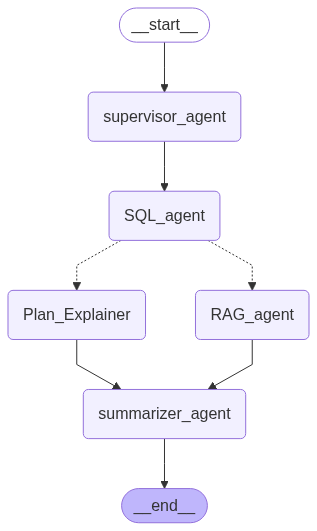

In [65]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

Intent = "plan"

In [30]:
sample_state = {
    "messages": [
        HumanMessage(content="Hi my customer id is CUST1007. I would like to check for alternative options from my currently subscribed plan to have more calls and data. I am not having extra data")
    ]
}

Intent = "Complaint"

In [66]:
sample_state = {
    "messages": [
        HumanMessage(content="I got to dispute a phone bill, I need help")
    ]
}

In [67]:
from langchain_core.messages import HumanMessage

flow_response = app.invoke(sample_state)

--------------------------Supervisor---------------------------
Parsed Response:  customer_id='CUST1234' intent='Complaint' query='I got to dispute a phone bill, I need help' Reasoning='The user is reporting a billing issue, which falls under the Complaint category.'
------------ SQL Agent Node ------------


> Entering new AgentExecutor chain...
Thought: I need to construct a SQL query to select customer details for a specific ID from the 'customers' table. 
Action: sql_db_query_checker
Action Input: SELECT * FROM customers WHERE customer_id = 'CUST1234'
Observation: SELECT * FROM customers WHERE customer_id = 'CUST1234' 

Thought:Thought: The query looks correct. I can execute it now.
Action: sql_db_query
Action Input: SELECT * FROM customers WHERE customer_id = 'CUST1234'
Observation: Error: (sqlite3.OperationalError) no such table: customers
[SQL: SELECT * FROM customers WHERE customer_id = 'CUST1234']
(Background on this error at: https://sqlalche.me/e/20/e3q8)
Thought:Thought: I 

Github Push

In [ ]:
# # Mock setup
# from langchain_core.prompts import PromptTemplate
# from langchain_core.language_models.fake import FakeListLLM  # Use for testing if you don't have a real LLM

# # Dummy LLM for testing
# # llm = FakeListLLM(responses=["This is a test summary response."])
# llm = ChatGroq(temperature=0, model_name="deepseek-r1-distill-llama-70b", streaming=True)
# # Define a fake AgentState (mock input)
# AgentState = dict  # You can also use TypedDict if structured

# # Sample test input (for a 'plan' intent)
# test_state = {
#     "intent": "",
#     "customer_id": "CUST1234",
#     "user_query": "Hi my customer id is CUST1007. I would like to check for alternative options from my currently subscribed plan to have more calls and data. I am not having extra data",
#     "plan_details": "Basic 2GB/day Plan, valid for 28 days.",
#     "query_response": "We see you're on a basic plan with 2GB/day data usage.",
#     "cross_sell_recommendation": "You may upgrade to our Premium 5GB/day Plan for better speed and data volume.",
#     "messages": []
# }

# # Your summarizer_agent function here (already defined above)

# # Run the test
# result = summarizer_agent(test_state)

# # Print output
# print("\n--- Summary Output ---")
# print(result["summary"])

# print("\n--- Messages ---")
# print(result["messages"])

# # def extract_summary_text(result: str) -> str:
# #     # Split after </think>
# #     if "</think>" in result:
# #         return result.split("</think>")[-1].split("---")[0].strip()
# #     return result  # fallback if no <think> tag
# # print("\n--- Extracted Summary Text ---")
# # print(extract_summary_text(result["summary"]))


--------------------------Summarizer Node---------------------------
Intent: plan
Generated Summary: <think>
Okay, so I need to help this user who's concerned about their current telecom plan. They mentioned they're on the Basic 2GB/day plan and want more calls and data without extra charges. 

First, I should start with a friendly greeting and an apology to show empathy. Using emojis like 👋 and 😊 can make the message feel warmer. 

Next, I need to acknowledge their current plan, the Basic 2GB/day, and express understanding that they're looking for more data and calls. 

Then, I should recommend an upgrade to the Premium 5GB/day plan. I should explain the benefits in a simple way, like better speed and more data, which would help them stay connected without worrying about running out. 

I should keep the tone conversational and avoid any technical jargon. Finally, I'll end with a question to see if they want help upgrading or exploring other options. 

I need to make sure the message f

In [ ]:
# for output in app.stream(sample_state):
#     for key,value in output.items():
#         print(f"Output from {key} Node")
#         print("________________________________________________________________________")
#         print(value)
#         print("\n")